# All you ever wanted to ask/know about multi-threading / multi-processing and you never dared to ask

In this notebook I will show some concepts/definitions and runnable code snippets to cover the following topics:
* Multi-threading in python
* Multi-processing in python
* Typical patterns
* Typical problems

Some resources which I found useful: [1](https://tenthousandmeters.com/blog/python-behind-the-scenes-13-the-gil-and-its-effects-on-python-multithreading/), [2](https://opensource.com/article/17/4/grok-gil#:~:text=This%20polite%20conduct%20is%20called,events%20at%20the%20same%20time.&text=Only%20one%20of%20these%20two,the%20other%20thread%20can%20run)

## 1. Let's start with some basics...

* `Process`: Instance of a computer program that is currently being executed. It has an ID, a stack, a heap, ...
* `Thread`: Independent flow of control within a Process. A single process can have many of these, and it has at least one (the main thread). Threads share the same address memory (heap) but have their own stack.
* `Multi-threading`: Creation of multiple threads by a single process.
* `User thread`: A Thread created via the library of a certain language (e.g. Python).
* `OS / Kernel thread`: A Thread that is created via a lower level library, at the OS level.
* `Multi-processing`: Creation of more than one Process (e.g. child processes) during the same program call (parent process).

## 2. Why bother with multi-threading at all?

* Computers have typically more than one CPU (logical / physical), so more than one thread/process (Thread = Lightweight Process!) [3](https://unixhealthcheck.com/blog?id=465) can typically run in parallel
* Even a single CPU can run more than one thread/process efficiently because of "waiting" time
    * Things that cause waiting time: Waiting for user input, waiting for I/O, sleeping, ...

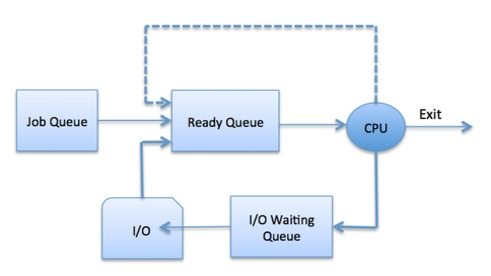

## 3. How does this affect me as a programmer?

* Each programming language has typically a `Threading Library` which allows for the creation of `User Threads`.
* The programmer can then write and coordinate different related tasks on different threads.
* Each programming language's interpreter/VM maps `User Threads` to `OS / Kernel Threads` using something like e.g. the [Native POSIX Thread Library](https://en.wikipedia.org/wiki/Native_POSIX_Thread_Library) (depending on the underlying OS). Sometimes the programming language also offers a higher level of abstraction for threads called "greenlets" or "green threads".
* The created `OS / Kernel Threads` are then known to the OS and scheduled by the OS Scheduler.
* On top of that, the interpreter/VM "mediates" the execution of those threads according to one of the following models:

#### M:1 model (e.g. Python)

*Only one User Thread at a time can execute Python operations. In Python, the GIL is acquired/released periodically to alternate different user threads. (Typical model for languages that have reference-counting memory management, which is a kind of memory management that is not thread-safe)*

#### 1:1 model (e.g. Java)

*The interpreter/VM will create one Kernel Thread for each User Thread, and will not interfere with the OS's scheduler.*

#### M:N model (e.g. Go, Rust)

*Complex model which combines a user-level scheduler with kernel-level scheduling.*

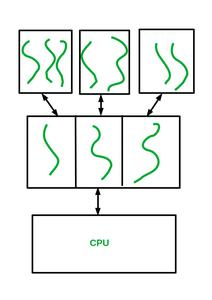

## 4. What are Python threads good for?

* Python threads are not good for splitting CPU-intensive tasks, because of the GIL.
* The following code is faster with one user thread than with many:

In [3]:
%%time
def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res = res * i
    return res

for i in range(0, 100):
    factorial(10000)

CPU times: user 2.4 s, sys: 11.8 ms, total: 2.42 s
Wall time: 2.47 s


In [4]:
%%time
import concurrent.futures

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res = res * i
    return res

# One way of scheduling user-threaded code is through an Executor
with concurrent.futures.ThreadPoolExecutor(max_workers=100) as executor:
    futures = []
    for i in range(0, 100):
        # submit() returns a Future, not the result
        futures.append(executor.submit(factorial, 10000))
    for future in futures:
        # By calling result() we block until the result for this Future is available,
        # however this only blocks the main thread, not the executor ones
        future.result()

CPU times: user 2.46 s, sys: 29.4 ms, total: 2.49 s
Wall time: 2.57 s


* Python threads are good for splitting tasks which could potentially block on I/O (e.g. doing network calls).
* It is more efficient to have several threads than to have several processes for that (less overhead).
* The following code will run in the same amount of time more or less, regardless of how many threads we use:

In [6]:
%%time
import time
from threading import Thread

N_THREADS = 10

def func():
    time.sleep(1)  # releases the GIL, goes on WAIT state

threads = []

# Another way of scheduling user-threaded code is through manual
# creation of Thread objects
for i in range(0, N_THREADS):
    t = Thread(target=func)
    t.start()
    # We need to keep a reference to each of them
    threads.append(t)

for t in threads:
    # Similar to future.result(), block until this thread has finished
    t.join()

CPU times: user 3.75 ms, sys: 3.9 ms, total: 7.66 ms
Wall time: 1.05 s


## 5. Synchronization issues / Interruptions

* The following code increments a counter using several threads.
* The code is not thread-safe because it relies on a local reference of the global counter, and an interruption could happen in the middle of the func() function. In this case, the output would not be as expected.
* Thread schedulers usually alternate CPU time between several threads/processes in a "fair" way. Whenever the scheduler switches between one process to another, a *context switch* happened. 
* One possible solution to make this code safe is to use a Lock object (a *mutex* flag).
* If you uncomment the code that uses the lock, you will see the difference:

In [13]:
import time
from threading import Thread, Lock

my_counter = 0

N_THREADS = 100
STUPIDITY_WINDOW = 100000

lock = Lock()

def func():
    global my_counter
    lock.acquire()
    val = my_counter
    
    # Do some stupid things just to take more CPU time
    for i in range(0, STUPIDITY_WINDOW):
        # At some point we will get interrupted here (unless we use a Lock)
        val += 1
        val -= 1

    val += 1
    my_counter = val
    lock.release()

threads = []

for i in range(0, N_THREADS):
    t = Thread(target=func)
    t.start()
    threads.append(t)
    
for t in threads:
    t.join()

print(my_counter)

100


## 6. A typical multi-threading pattern: consumer/producer

* Let's see one of the most used patterns in concurrent programming.
* Example: a web server accepting requests using some threads, which produces dispatchable work that can be done asynchronously (e.g. recalculating something) by another set of threads.
* The queue has usually a fixed size (to avoid memory explosion) and allows for blocking put() / get() operations.
* Allows for different speeds in producing / consuming work.
* Typically we use thread-safe flags to terminate threads politely, or alternatively a "poison pill" (a message which is interpreted as a shutdown order).

In [1]:
import time
import queue
from threading import Thread, Event

QUEUE_SIZE = 2
CONSUMER_SPEED = 2
PRODUCER_SPEED = 1

q = queue.Queue(QUEUE_SIZE)

# Event has "atomic" operations for setting and unsetting a flag
shutdown = Event()

def consumer():
    while(not shutdown.is_set()):
        msg = q.get(block=True)
        print(f'consumer got: {msg}')
        time.sleep(CONSUMER_SPEED)
    print('Bye bye from consumer!')

def producer():
    while(not shutdown.is_set()):
        time.sleep(PRODUCER_SPEED)
        try:
            q.put('A message', timeout=1)
            #print('-> producer just put a message')
        except queue.Full:
            print('producer: Queue is full')
    print('Bye bye from producer!')

p_thread = Thread(target=producer)
c_thread = Thread(target=consumer)
p_thread.start()
c_thread.start()

time.sleep(10)

shutdown.set()

p_thread.join()
c_thread.join()

consumer got: A message
consumer got: A message
consumer got: A message
consumer got: A message
consumer got: A message
Bye bye from consumer!producer: Queue is full

Bye bye from producer!


* Note: C extensions that are invoked from Python do not lock on the GIL and can use OS threads freely! (e.g. numpy)

## 7. Multi-processing with Python

* Python has an alternative API called `multiprocessing` which implements most of the same elements as the `threading` API, and some more.
* This API is widely used to overcome the limitations of the threading model and the GIL.
* However it has a bigger overhead because e.g. each process has its own interpreter, stack & heap, etc.
* The following example uses a *Pool* to send work to a fixed set of processes. The function and arguments passed via *map* are serialized using pickle.
* Note how we use a multi-processing Lock, which is just a portion of shared memory provided by the OS which can be acquired and released by multiple processes.
* A Lock is a particular case of Semaphore, which allows for more than one process to enter the *mutex*-portion of the code.

In [1]:
import time
import os

from multiprocessing import Pool, Lock

def f(x):
    # a multiprocessing Lock is a wrapper to a OS (e.g. POSIX) Semaphore which is created by the
    # parent process and shared via inheritance with child processes
    with lock:
        print(f'Hello I am process "{os.getpid()}" and I was created by process "{os.getppid()}" - ')
    time.sleep(1)
    return x*x

def init(l):
    # this is a trick to be able to use multiprocessing primitives created by the
    # parent processes, in child processes, when using Pool.map()
    global lock
    lock = l

if __name__ == '__main__':
    l = Lock()
    with Pool(initializer=init, initargs=(l,), processes=5) as p:
        # args to map's function will be pickled to child processes
        print(p.map(f, [1, 2, 3,]))

Hello I am process "170382" and I was created by process "170105" - 
Hello I am process "170384" and I was created by process "170105" - 
Hello I am process "170383" and I was created by process "170105" - 
[1, 4, 9]


## 8. How do multiple processes communicate?

Communication between processes can no longer be achieved via simple variables/data structures, as each process has its own heap.

Instead, one can use:

* Multiprocessing primitives e.g. Queue / Pipe (implemented via OS primitives like named pipes)
* Shared-memory wrappers e.g. multiprocessing.Value
* Direct shared-memory blocks - available in Python 3.8, use with care!
* External devices (files, databases, etc)
* Direct/custom IPC communication (e.g. through sockets)

In this example we will use shared memory to increment/decrement a variable:

In [21]:
import multiprocessing

def deposit(balance, lock):
    for i in range(500):
        with lock:
            balance.value = balance.value + 1

def withdraw(balance, lock):
    for i in range(500):
        with lock:
            balance.value = balance.value - 1

if __name__ == '__main__':
    # shared-memory variable
    balance = multiprocessing.Value('i', 500)
    lock = multiprocessing.Lock()
    # Here "balance" and "lock" are shared via inheritance (not serialized via pickle)
    p1 = multiprocessing.Process(target=deposit, args=(balance, lock))
    p2 = multiprocessing.Process(target=withdraw, args=(balance, lock))
    p1.start()
    p2.start()
    p1.join()
    p2.join()
    print(balance.value)

500


## 9. Multi-processing "managers"

* Python offers "Managers" which are separate processes that can mediate between several process to e.g. concurrently modify a complex data structure like a dictionary.
* Let's see a concrete example:

In [22]:
import multiprocessing

def worker(d, key, value):
    d[key] = value

if __name__ == '__main__':
    mgr = multiprocessing.Manager()
    # a Manager is another process which is used for process-safe operations
    print('Manager process pid:', mgr._process.ident);
    d = mgr.dict()

    jobs = [multiprocessing.Process(target=worker, args=(d, i, i*2))
            for i in range(10)]

    for j in jobs:
        j.start()
    for j in jobs:
        j.join()

    print(d)

Manager process pid: 50750
{0: 0, 1: 2, 2: 4, 5: 10, 4: 8, 6: 12, 7: 14, 8: 16, 3: 6, 9: 18}


## 10. Multiprocessing "start method"

* Child processes can be created from a parent process in slightly different ways, with potential side effects.
* On UNIX-sytems, by default `fork()` is used.

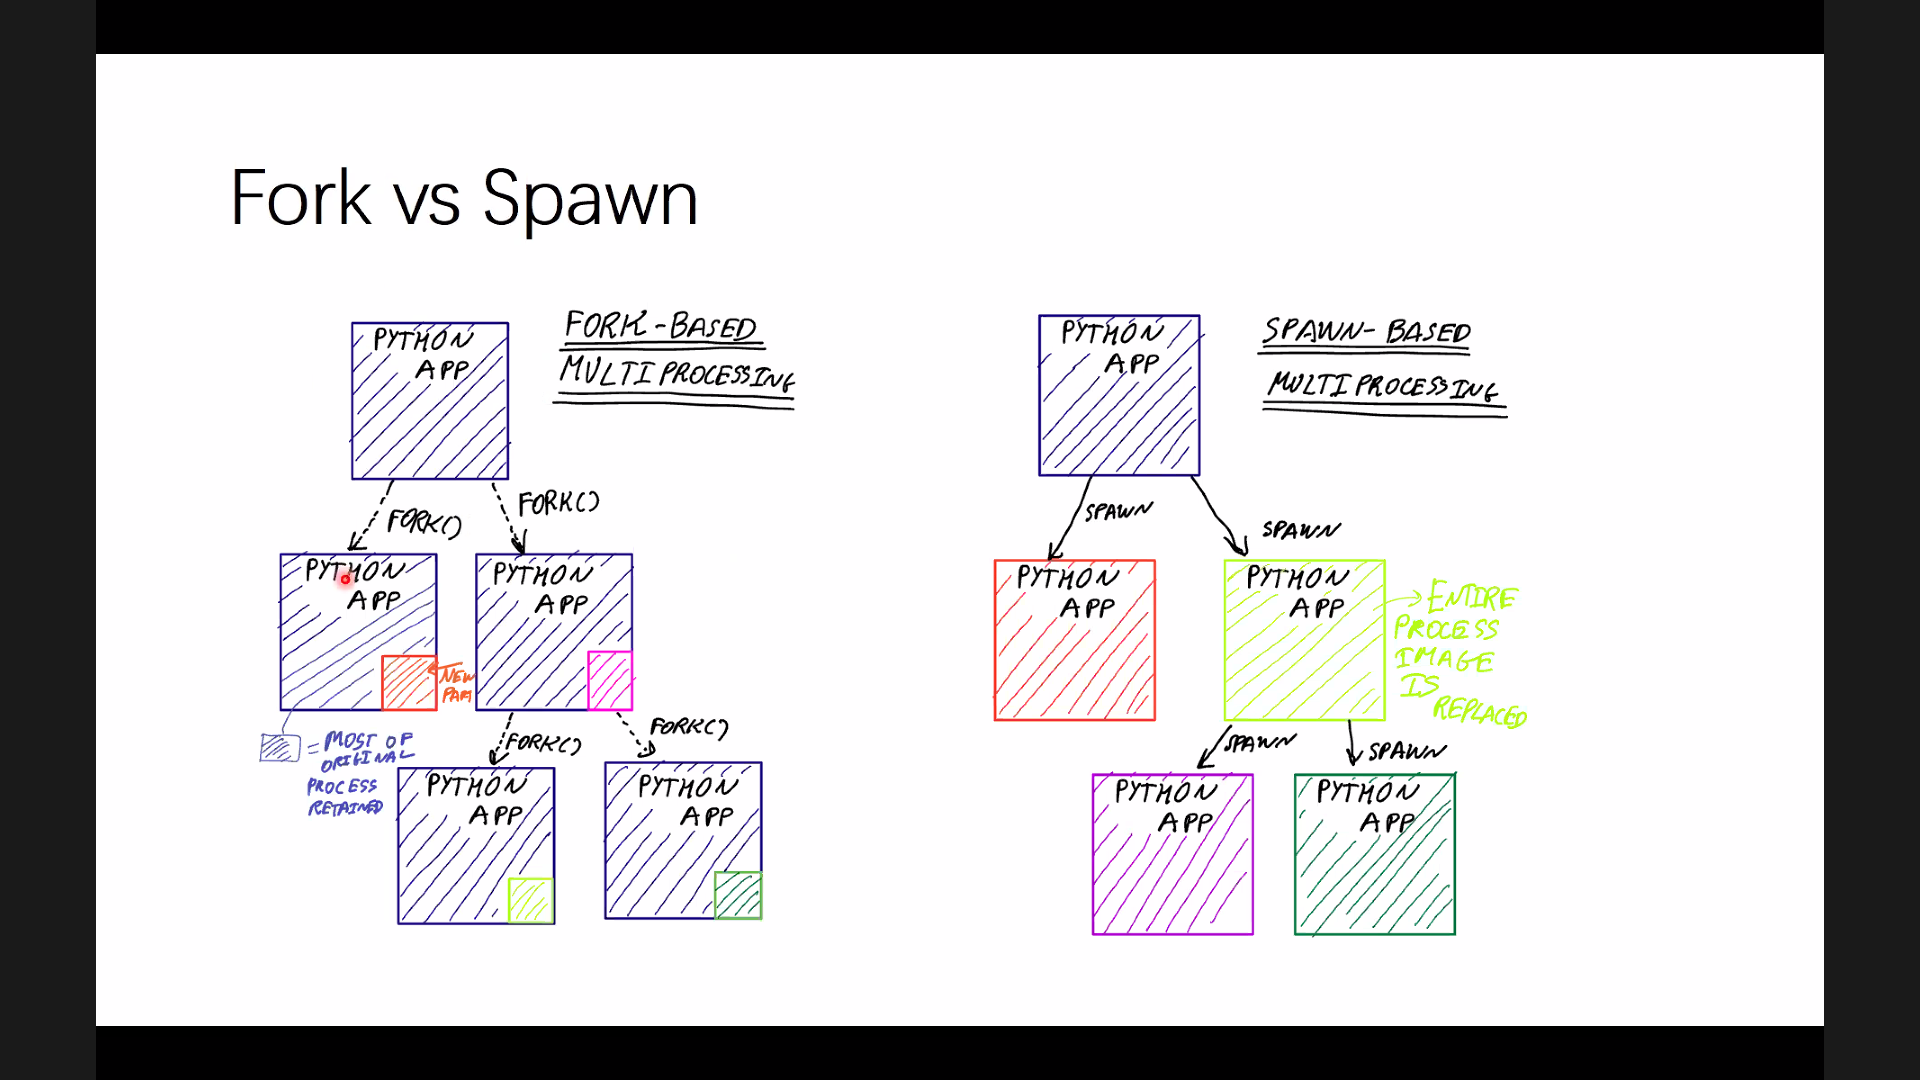

* `fork()` copies almost all of parent's process memory (either a direct copy or copy-on-write) - considered unrealiable, see for example [this link](http://www.doublersolutions.com/docs/dce/osfdocs/htmls/develop/appdev/Appde193.htm)
* `spawn()` creates a new process with a new python interpreter, and serializes the necessary context (function/class) through pickle, leading to a cleaner state
* `forksever()` creates a specialized process with minimal state from where child processes are forked

## 11. Typical problems with multi-threading/multi-processing

* One of the most common problems in concurrent programming is to forget about threads and not terminate them properly e.g.:

In [23]:
import time
from threading import Thread

def func():
    time.sleep(5)
    print('Im still alive!')

threads = []

for i in range(0, 2):
    t = Thread(target=func) # add daemon=True to avoid the need to join() later
    t.start()
    threads.append(t)

print('Bye from the main thread!')

# Here we forgot to join() the threads that we created, which can cause problems
# Alternatively, we could have declared the threads as "daemon" threads (detached),
# e.g. see https://man7.org/linux/man-pages/man3/daemon.3.html

Bye from the main thread!
Im still alive!
Im still alive!


Other problems are:
* Not noticing that a background Thread died silently (one should catch all Exceptions from such threads and log them properly).
* Synchronization issues (already seen in examples above).
* Complexity - problems debugging, logging, etc.
* Deadlocks (in theory, not so frequent in practice).
* Starvation if e.g. one thread can almost never enter a mutex portion of the code.
* Mixing multi-threading-safe code with multi-processing-safe code (e.g. locking on a `multithreading.Lock` instead of locking on a `multiprocessing.Lock`)
* Sharing "too much state" from the parent process onto child processes (state which cannot be easily serialized):

In [24]:
import os
import multiprocessing
import threading

class MyClass:

    def __init__(self):
        self.lock = threading.RLock()

    def my_func(self):
        with self.lock:
            print('To be executed from multiple processes')

    def run(self):
        with self.lock:
            p = multiprocessing.Process(target=self.my_func)
            p.start()
            p.join()

my_class = MyClass()

try:
    with multiprocessing.Pool(processes=2) as p:
        print(p.map(my_class.my_func, [1, 2]))
except TypeError as e:
    print('Trying to serialize too much state into children processes!')
    print(e)

Trying to serialize too much state into children processes!
cannot pickle '_thread.RLock' object


### I hope that this guide was useful to you. Now you shall use all this knowledge with care :-)